# 1 Introduction
In this experiment we try to explore whether COVID-19 deepen the social segregation.Our null hypothesis is: COVID-19 have no influence towards social segregation, and then use logistic regression to examine that.

In [2]:
# QM-FINAL
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2 data preprocess
We need to input some data and try to combine them into one table. These datasets are:
1. socio-economic data related to health status, provided by America’s Health Rankings
2. COVID cases data provided by Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)
3. COVID vaccination data provided by CDC

In dataset 1, we extract some data about socio-economic status about states in USA.

In [3]:
# drop unrelated columns. In this experiment we drop the Edition, Report Type, Lower CI, Upper CI, Source, Source Year
se_data_2017_path = r'E:\casa\casa0007\final\data\socioeconomic\2017-Annual.csv'
se_data_2017 = pd.read_csv(se_data_2017_path)
se_data_2017 = se_data_2017.drop(se_data_2017[(se_data_2017['Measure Name'] == 'Drug Deaths') & (se_data_2017['Source Year'] == '2013-2015')].index)
se_data_2017 = se_data_2017.drop(se_data_2017[(se_data_2017['Measure Name'] == 'Children in Poverty') & (se_data_2017['Source'] == 'U.S. Census Bureau, American Community Survey')].index)

se_data_2018_path = r'E:\casa\casa0007\final\data\socioeconomic\2018-Annual.csv'
se_data_2018 = pd.read_csv(se_data_2018_path)
se_data_2018 = se_data_2018.drop(se_data_2018[(se_data_2018['Measure Name'] == 'Drug Deaths') & (se_data_2018['Source Year'] == '2014-2016')].index)

se_data_2019_path = r'E:\casa\casa0007\final\data\socioeconomic\2019-Annual.csv'
se_data_2019 = pd.read_csv(se_data_2019_path)
se_data_2019 = se_data_2019.drop(se_data_2019[(se_data_2019['Measure Name'] == 'Drug Deaths') & (se_data_2019['Source Year'] == '2015-2017')].index)


se_data_2020_path = r'E:\casa\casa0007\final\data\socioeconomic\2020-Annual.csv'
se_data_2020 = pd.read_csv(se_data_2020_path)

se_data_2021_path = r'E:\casa\casa0007\final\data\socioeconomic\2021-Annual.csv'
se_data_2021 = pd.read_csv(se_data_2021_path)

In [4]:
# Then we pick up some useful columns and drop the information such as data source.
se_data_2017 = se_data_2017.iloc[:,2:6]
se_data_2018 = se_data_2018.iloc[:,2:6]
se_data_2019 = se_data_2019.iloc[:,2:6]
se_data_2020 = se_data_2020.iloc[:,2:6]
se_data_2021 = se_data_2021.iloc[:,2:6]

In [5]:
# I have pick some types of factors and write them in metadata.xlsx
metadata_path = r'E:\casa\casa0007\final\data\metadata.xlsx'
metadata = pd.read_excel(metadata_path, header = None)
metadata = metadata[0].tolist()
metadata_set = set(metadata)
metadata_set

{'Adverse Childhood Experiences',
 'Air Pollution',
 'Anxiety',
 'Below poverty threshold',
 'Child Victimization',
 'Children in Poverty',
 'Children in Poverty Racial Disparity',
 'Community and Family Safety - Annual',
 'Concentrated Disadvantage',
 'Crowded Housing',
 'Dependency',
 'Drug Deaths',
 'Early Childhood Education',
 'Economic Resources - Annual',
 'Education - Annual',
 'Education - Less Than High School',
 'Excessive Drinking',
 'Female-headed household',
 'Flourishing',
 'Food Insecurity',
 'Food Sufficiency',
 'Foster Care Instability',
 'Fourth Grade Reading Proficiency',
 'High School Graduation',
 'High School Graduation Racial Disparity',
 'Homeownership',
 'Homeownership Racial Disparity',
 'Housing With Lead Risk',
 'Illicit Drug Use - Youth',
 'Income Inequality',
 'Intimate Partner Violence Before Pregnancy',
 'Neighborhood Amenities',
 'Obesity',
 'Occupational Fatalities',
 'Overweight or Obesity - Youth',
 'Per Capita Income',
 'Population under 18 years',

In [6]:
# we pick up the socio-economic factors that we are interested in. We select the factors both in metadata.xlsx and dataset.
se_data_useful_2017 = se_data_2017[se_data_2017['Measure Name'].isin(metadata_set)]
print('2017 data:', len(se_data_useful_2017)/ 52 , 'factors')

se_data_useful_2018 = se_data_2018[se_data_2018['Measure Name'].isin(metadata_set)]
print('2018 data:', len(se_data_useful_2018)/ 52 , 'factors')

se_data_useful_2019 = se_data_2019[se_data_2019['Measure Name'].isin(metadata_set)]
print('2019 data:', len(se_data_useful_2019)/ 52 , 'factors')

se_data_useful_2020 = se_data_2020[se_data_2020['Measure Name'].isin(metadata_set)]
print('2020 data:', len(se_data_useful_2019)/ 52 , 'factors')

se_data_useful_2021 = se_data_2021[se_data_2021['Measure Name'].isin(metadata_set)]
print('2021 data:', len(se_data_useful_2019)/ 52 , 'factors')

2017 data: 14.0 factors
2018 data: 25.0 factors
2019 data: 29.0 factors
2020 data: 29.0 factors
2021 data: 29.0 factors


In [7]:
# Then we need to an important step, which is rearrange the data and let all needed data into one table annually. 
# In this step I design a function to achieve that.
def data_rearrange(data):
    '''
    rearrange data into a table
    '''
    dataset = pd.DataFrame()
    se_data_groupby_factors = data.groupby('Measure Name')
    i = 0
    for unit in se_data_groupby_factors:
        temp = pd.DataFrame(columns=['state',unit[0]])
        temp['state'] = unit[1].iloc[:,1]
        temp[unit[0]] = unit[1].iloc[:,3]
    #     print('dataset:',dataset)
    #     print('temp:',temp)
        if i == 0:
            dataset = temp
        else:
            dataset = dataset.merge(temp,how='left', on='state')

        i+=1

    dataset = dataset.drop_duplicates(ignore_index=True)
    
    return dataset

In [8]:
# Though observing we can find that there are two rows related to United States, so we drop one.
dataset_2017 = data_rearrange(se_data_useful_2017)
dataset_2017 = dataset_2017.sort_values(by=['state'],ignore_index=True)
dataset_2017.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_table\2017.csv',index=None)

dataset_2018 = data_rearrange(se_data_useful_2018)
dataset_2018 = dataset_2018.sort_values(by=['state'],ignore_index=True)
dataset_2018.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_table\2018.csv',index=None)

dataset_2019 = data_rearrange(se_data_useful_2019)
dataset_2019 = dataset_2019.sort_values(by=['state'],ignore_index=True)
dataset_2019.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_table\2019.csv',index=None)

dataset_2020 = data_rearrange(se_data_useful_2020)
dataset_2020 = dataset_2020.sort_values(by=['state'],ignore_index=True)
dataset_2020.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_table\2020.csv',index=None)

dataset_2021 = data_rearrange(se_data_useful_2021)
dataset_2021 = dataset_2021.drop(index=51)
dataset_2021 = dataset_2021.sort_values(by=['state'],ignore_index=True)
dataset_2021.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_table\2021.csv',index=None)

dataset_2017

,state,Air Pollution,Children in Poverty,Drug Deaths,Excessive Drinking,Food Insecurity,High School Graduation,Income Inequality,Neighborhood Amenities,Obesity,Occupational Fatalities,Public Health Funding,Severe Housing Problems,Violent Crime
0,Alabama,8.9,24.3,15.3,14.2,17.6,89.3,5.31,17.3,35.7,5.5,112.0,15.5,532.0
1,Alaska,8.7,18.3,16.2,19.1,13.3,75.6,3.91,31.8,31.4,5.9,285.0,21.0,804.0
2,Arizona,9.7,23.1,19.3,17.3,14.9,77.4,4.63,33.0,29.0,3.9,50.0,19.5,470.0
3,Arkansas,7.2,21.4,13.5,15.9,19.2,84.9,4.85,25.1,35.7,7.5,108.0,14.7,551.0
4,California,11.7,18.6,12.0,17.8,12.6,82.0,5.27,53.3,25.0,3.0,103.0,27.9,445.0
5,Colorado,6.6,8.4,15.6,20.6,12.1,77.3,4.41,57.2,22.3,4.0,98.0,17.3,343.0
6,Connecticut,8.6,16.3,22.1,18.4,13.1,87.2,4.90,39.1,26.0,3.5,82.0,19.0,227.0
7,Delaware,9.1,16.9,21.3,18.4,11.9,85.6,4.30,28.8,30.7,4.4,107.0,15.6,509.0
8,District of Columbia,10.4,22.6,21.0,29.0,13.2,68.5,8.20,73.5,22.6,6.1,507.0,21.6,1206.0
9,Florida,6.8,18.7,16.1,17.5,12.7,77.9,4.61,38.0,27.4,4.6,63.0,21.5,430.0


In [9]:
# We then do differential operations for data every year to calculate the rate of change.
# Since some of the data in this dataset are not updated annually, 
# we intersected all the data in order to match these rates of change.
delta_18_17 = dataset_2018.iloc[:,1:] - dataset_2017.iloc[:,1:] 
delta_18_17 = delta_18_17.dropna(axis=1,how='all') 
delta_18_17['states'] = dataset_2018.iloc[:,0]
delta_18_17['label'] = 'before_covid'
delta_18_17 = delta_18_17.replace(0,np.nan)
delta_18_17 = delta_18_17.dropna(how='all',axis=1)
delta_18_17 = delta_18_17.replace(np.nan,0)

delta_19_18 = dataset_2019.iloc[:,1:] - dataset_2018.iloc[:,1:] 
delta_19_18 = delta_19_18.dropna(axis=1,how='all') 
delta_19_18['states'] = dataset_2019.iloc[:,0]
delta_19_18['label'] = 'before_covid'
delta_19_18 = delta_19_18.replace(0,np.nan)
delta_19_18 = delta_19_18.dropna(how='all',axis=1)
delta_19_18 = delta_19_18.replace(np.nan,0)

delta_20_19 = dataset_2020.iloc[:,1:] - dataset_2019.iloc[:,1:] 
delta_20_19 = delta_20_19.dropna(axis=1,how='all')  
delta_20_19['states'] = dataset_2020.iloc[:,0]
delta_20_19['label'] = 'after_covid'
delta_20_19 = delta_20_19.replace(0,np.nan)
delta_20_19 = delta_20_19.dropna(how='all',axis=1)
delta_20_19 = delta_20_19.replace(np.nan,0)

delta_21_20 = dataset_2021.iloc[:,1:] - dataset_2020.iloc[:,1:] 
delta_21_20 = delta_21_20.dropna(axis=1,how='all')  
delta_21_20['states'] = dataset_2021.iloc[:,0]
delta_21_20['label'] = 'after_covid'
delta_21_20 = delta_21_20.replace(0,np.nan)
delta_21_20 = delta_21_20.dropna(how='all',axis=1)
delta_21_20 = delta_21_20.replace(np.nan,0)

#取交集
set1 = (delta_19_18.columns & delta_20_19.columns)
set2 = (set1 & delta_21_20.columns)
set3 = (set2 & delta_18_17.columns)
len(set2)

<ipython-input-9-7b93ae0ba142>:37: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  set1 = (delta_19_18.columns & delta_20_19.columns)
<ipython-input-9-7b93ae0ba142>:38: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  set2 = (set1 & delta_21_20.columns)
<ipython-input-9-7b93ae0ba142>:39: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  set3 = (set2 & delta_18_17.columns)


20

we find out the data we used in the model

In [12]:
find_source = pd.read_csv(se_data_2019_path)

data_source = find_source[find_source['Measure Name'].isin(set2)]
data_source = data_source.loc[:,['Measure Name','Source']]
data_source = data_source.drop_duplicates(ignore_index=True)
data_source.to_csv(r'E:\casa\casa0007\final\source.csv')
data_source

,Measure Name,Source
0,Adverse Childhood Experiences,AHR data
1,Air Pollution,U.S. Environmental Protection Agency
2,Crowded Housing,"U.S. Census Bureau, American Community Survey"
3,Dependency,"U.S. Census Bureau, American Community Survey"
4,Drug Deaths,"CDC WONDER, Multiple Cause of Death Files"
5,Education - Less Than High School,"U.S. Census Bureau, American Community Survey"
6,Excessive Drinking,"CDC, Behavioral Risk Factor Surveillance System"
7,Food Insecurity,AHR data
8,High School Graduation,"U.S. Department of Education, National Center ..."
9,Income Inequality,"U.S. Census Bureau, American Community Survey"


then we merge all the data into one dataset, and give them label: data in 2017-19 are "before_covid", and data in 19-20 are "after_covid"
Then we save them into csv files.

In [11]:
delta_21_20_filter = delta_21_20.loc[:,set2]
delta_20_19_filter = delta_20_19.loc[:,set2]
delta_19_18_filter = delta_19_18.loc[:,set2]
delta_18_17_filter = delta_19_18.loc[:,set2]

delta_21_20_filter = delta_21_20_filter.drop(delta_21_20_filter[delta_21_20_filter['states'] == 'West Virginia'].index)
delta_21_20_filter = delta_21_20_filter.drop(delta_21_20_filter[delta_21_20_filter['states'] == 'Utah'].index)
delta_21_20_filter = delta_21_20_filter.drop(delta_21_20_filter[delta_21_20_filter['states'] == 'Wisconsin'].index)

delta_20_19_filter = delta_20_19_filter.drop(delta_20_19_filter[delta_20_19_filter['states'] == 'West Virginia'].index)
delta_20_19_filter = delta_20_19_filter.drop(delta_20_19_filter[delta_20_19_filter['states'] == 'Utah'].index)
delta_20_19_filter = delta_20_19_filter.drop(delta_20_19_filter[delta_20_19_filter['states'] == 'Wisconsin'].index)

delta_19_18_filter = delta_19_18_filter.drop(delta_19_18_filter[delta_19_18_filter['states'] == 'West Virginia'].index)
delta_19_18_filter = delta_19_18_filter.drop(delta_19_18_filter[delta_19_18_filter['states'] == 'Utah'].index)
delta_19_18_filter = delta_19_18_filter.drop(delta_19_18_filter[delta_19_18_filter['states'] == 'Wisconsin'].index)

delta_18_17_filter = delta_18_17_filter.drop(delta_18_17_filter[delta_18_17_filter['states'] == 'West Virginia'].index)
delta_18_17_filter = delta_18_17_filter.drop(delta_18_17_filter[delta_18_17_filter['states'] == 'Utah'].index)
delta_18_17_filter = delta_18_17_filter.drop(delta_18_17_filter[delta_18_17_filter['states'] == 'Wisconsin'].index)

df_concat = pd.concat([delta_19_18_filter,delta_20_19_filter],axis=0,ignore_index=True)
df_concat = pd.concat([df_concat,delta_21_20_filter],axis=0,ignore_index=True)
df_concat = pd.concat([df_concat,delta_18_17_filter],axis=0,ignore_index=True)
delta_21_20_filter

,Adverse Childhood Experiences,Air Pollution,Crowded Housing,Dependency,Drug Deaths,Education - Less Than High School,Excessive Drinking,Food Insecurity,High School Graduation,Income Inequality,Obesity,Occupational Fatalities,Per Capita Income,Poverty,Public Health Funding,Severe Housing Problems,Unemployment,Violent Crime,states,label
0,0.9,-0.2,0.0,0.0,-0.2,0.0,0.7,-0.7,1.7,0.00,2.9,-0.8,0.0,0.0,13.0,-0.2,0.0,0.0,Alabama,after_covid
1,-3.0,-0.1,0.0,0.0,2.9,0.0,1.5,-0.2,1.9,0.00,1.4,-3.6,0.0,0.0,160.0,0.3,0.0,0.0,Alaska,after_covid
2,0.3,0.5,0.0,0.0,2.9,0.0,-0.2,-1.4,-0.9,0.00,-0.5,0.2,0.0,0.0,22.0,-0.3,0.0,0.0,Arizona,after_covid
3,-1.6,-0.1,0.0,0.0,-2.0,0.0,1.2,-2.5,-1.6,0.00,-1.0,-0.5,0.0,0.0,19.0,-0.1,0.0,0.0,Arkansas,after_covid
4,1.2,0.7,0.0,0.0,2.2,0.0,-0.3,-0.8,1.5,0.00,4.2,0.2,0.0,0.0,20.0,-0.2,0.0,0.0,California,after_covid
5,0.8,0.2,0.0,0.0,1.1,0.0,0.1,1.0,0.3,0.00,0.4,-0.1,0.0,0.0,23.0,-0.3,0.0,0.0,Colorado,after_covid
6,-0.1,0.3,0.0,0.0,4.1,0.0,-1.4,-0.6,0.1,0.00,0.1,-0.2,0.0,0.0,36.0,-0.1,0.0,0.0,Connecticut,after_covid
7,-1.7,-0.1,0.0,0.0,3.8,0.0,-3.0,-0.6,2.1,0.00,2.1,0.5,0.0,0.0,41.0,0.3,0.0,0.0,Delaware,after_covid
8,-1.9,-0.8,0.0,0.0,8.5,0.0,-2.8,-0.3,0.4,0.00,0.5,0.8,0.0,0.0,256.0,-0.4,0.0,0.0,District of Columbia,after_covid
9,-0.1,-0.1,0.0,0.0,2.5,0.0,-2.5,-1.6,0.9,0.00,1.4,-0.1,0.0,0.0,14.0,-0.3,0.0,0.0,Florida,after_covid


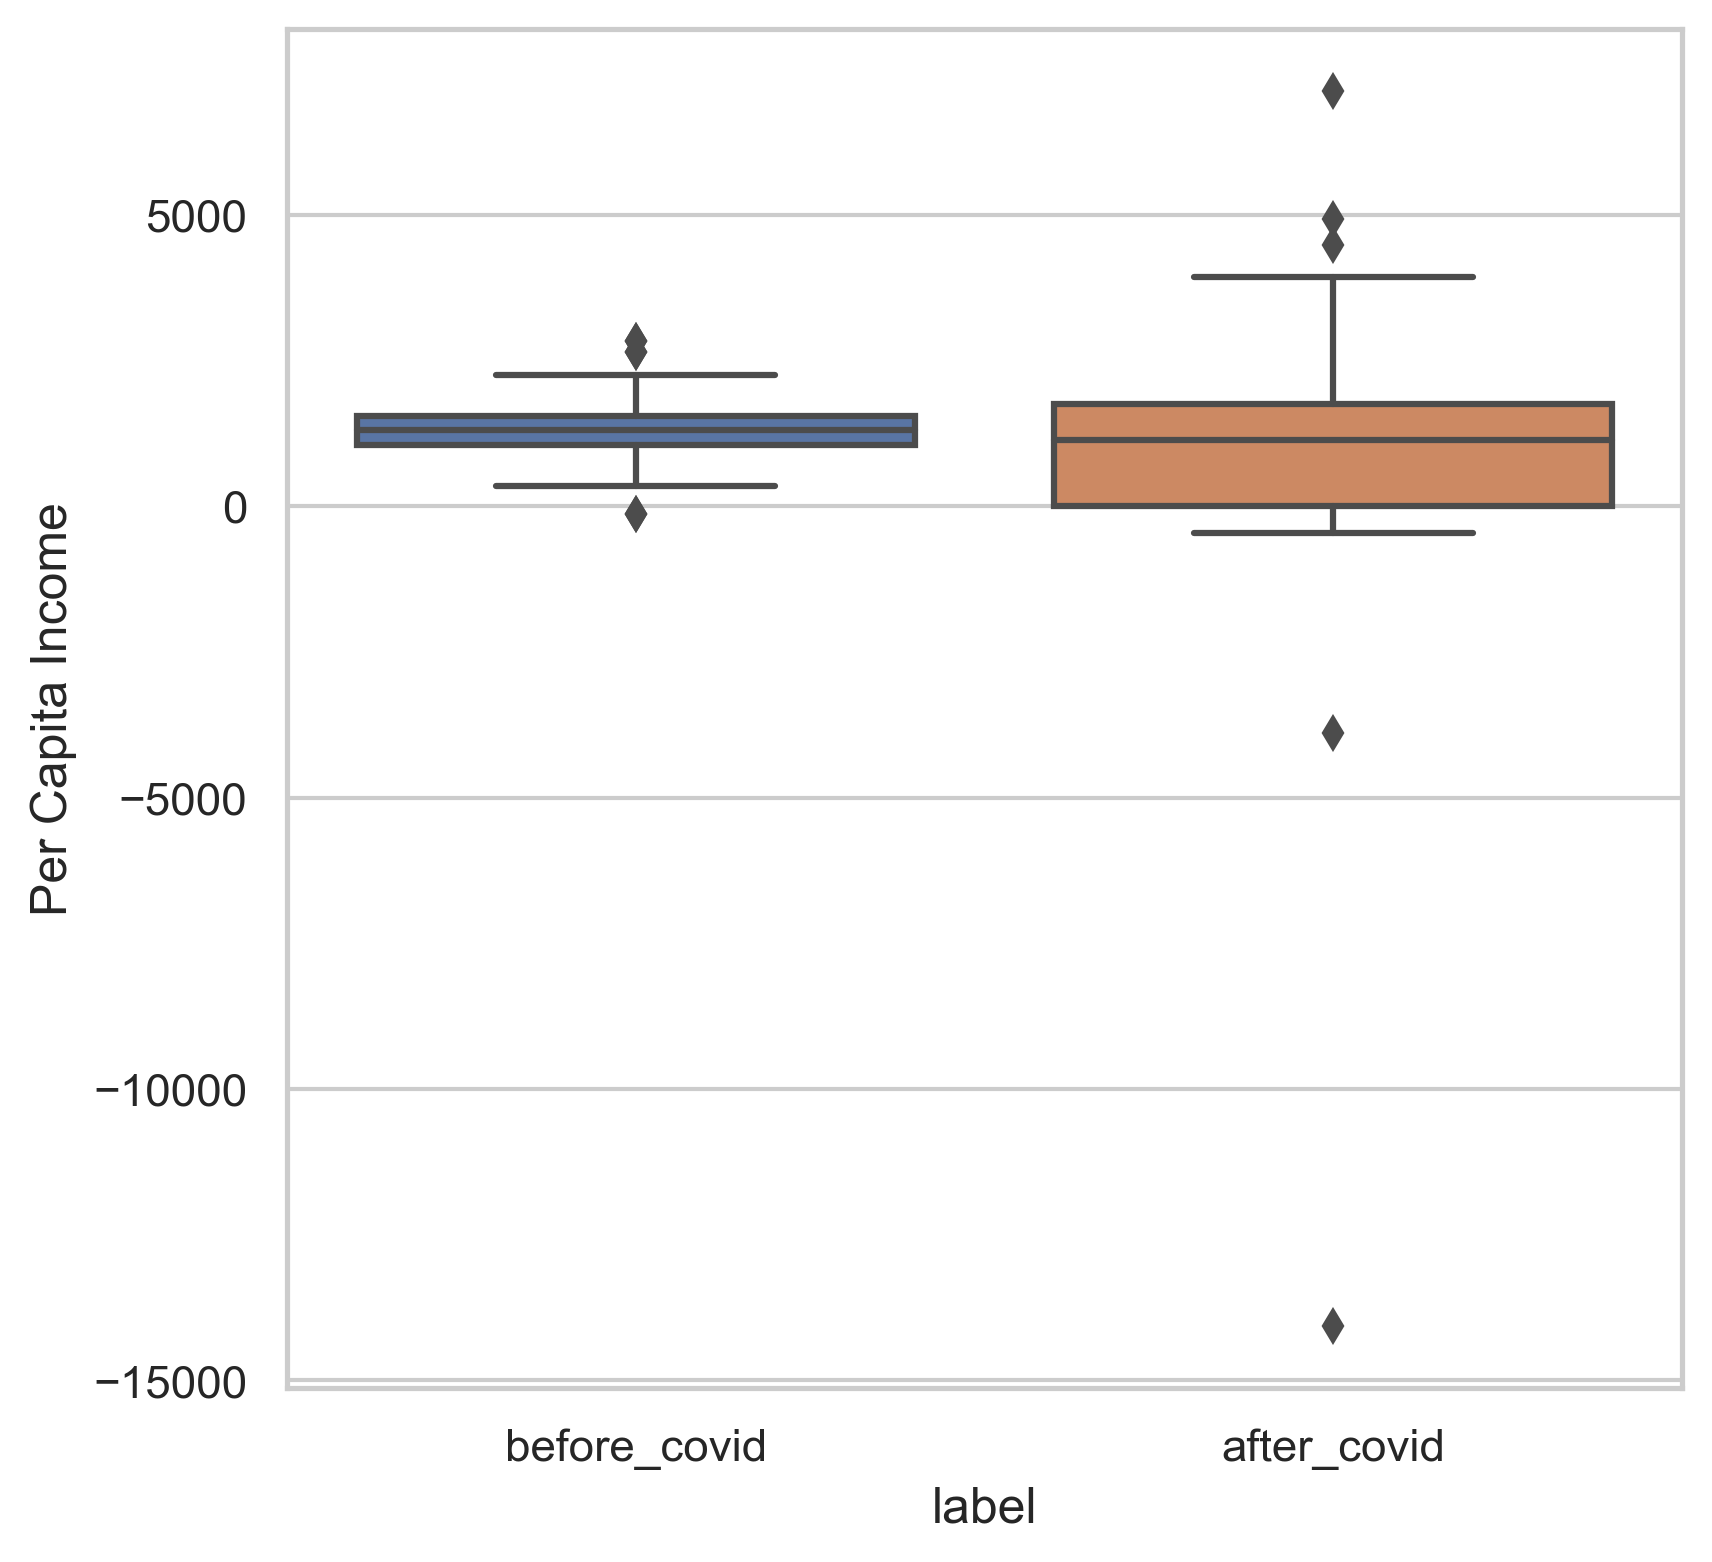

In [65]:
# boxplot
plt.figure(figsize=(6,6),dpi=300)

# plot Boxplot chart
sns.boxplot(x='label', y='Per Capita Income', data=df_concat)
# show the graph
plt.show()

In [14]:
# we find out the West Virginia, Utah, and Wisconsin are outliners.
# drop the outliner
df_concat = df_concat.drop(df_concat[df_concat['states'] == 'West Virginia'].index)
df_concat = df_concat.drop(df_concat[df_concat['states'] == 'Utah'].index)
df_concat = df_concat.drop(df_concat[df_concat['states'] == 'Wisconsin'].index)
df_concat

,Adverse Childhood Experiences,Air Pollution,Crowded Housing,Dependency,Drug Deaths,Education - Less Than High School,Excessive Drinking,Food Insecurity,High School Graduation,Income Inequality,Obesity,Occupational Fatalities,Per Capita Income,Poverty,Public Health Funding,Severe Housing Problems,Unemployment,Violent Crime,states,label
0,-1.4,-0.3,-0.1,0.4,1.7,-0.1,-0.1,-1.8,2.2,0.06,-0.1,0.1,1027.0,0.4,3.0,-0.6,-0.2,-4.0,Alabama,before_covid
1,0.3,-1.0,-0.7,0.5,3.0,-1.6,-3.6,-1.1,2.1,-0.10,-4.7,0.3,1513.0,0.3,2.0,-0.2,-0.8,56.0,Alaska,before_covid
2,-3.3,0.0,0.1,0.1,1.9,-0.3,0.5,-1.5,-1.5,-0.08,0.0,0.3,1110.0,-1.1,2.0,-0.5,-0.6,-33.0,Arizona,before_covid
3,-2.5,0.0,0.4,0.1,1.5,-0.5,0.0,-0.1,1.0,0.06,2.1,0.3,1310.0,0.3,0.0,-0.2,-1.0,-11.0,Arkansas,before_covid
4,-1.6,0.9,0.0,0.2,0.5,-0.5,-1.6,-0.6,-0.3,0.00,0.7,0.1,2078.0,-0.3,5.0,-0.4,-0.4,-2.0,California,before_covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-1.2,0.0,0.0,0.2,1.9,-0.3,-0.8,-0.7,0.5,0.01,-0.4,0.0,1434.0,-0.3,1.0,-0.5,-0.4,-13.0,United States,before_covid
192,1.6,-0.1,0.3,0.5,1.3,-0.9,-1.0,-0.3,1.4,-0.08,-0.1,0.5,1513.0,0.6,0.0,-0.1,-0.1,6.0,Vermont,before_covid
193,0.6,-0.3,0.1,0.3,1.1,-0.2,-0.5,0.2,0.2,0.14,0.3,-0.2,1458.0,0.3,4.0,-0.3,-0.4,-8.0,Virginia,before_covid
194,-0.9,0.0,0.1,0.2,0.7,-0.3,-0.9,-0.8,-0.3,-0.02,1.0,0.0,2144.0,-0.7,2.0,-0.3,-0.6,7.0,Washington,before_covid


In [15]:
delta_21_19 = delta_21_20_filter.iloc[:,:-2] - delta_20_19_filter.iloc[:,:-2]

delta_19_17 = delta_20_19_filter.iloc[:,:-2] - delta_19_18_filter.iloc[:,:-2]

mean_19_17,std_19_17 = delta_19_17.mean(),delta_19_17.std()
mean_21_19,std_21_19 = delta_21_19.mean(),delta_21_19.std()

df = pd.DataFrame({'17-19_mean':mean_19_17,
                  '17-19_std':std_19_17,
                  '19-21_mean':mean_21_19,
                  '19-21_std':std_21_19,})
df.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_output\data_description.csv')

In [16]:
delta_19_17.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_output\delta_17_19.csv')
delta_21_19.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_output\delta_19_21.csv')
delta_20_19.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_output\output.csv')

## 3. building classification models
In this part I build multi-nominal logistic regression(MNL) and support vector machine(SVM) to test if they can classify the data from before covid and after covid successfully, and record their accuracy score and confusion matrix. I use 80% of all the data as train dataset, and the rest of them as validation data. I also have done the **normalization** to make sure all the factors are limited in same scale.And I use 5-fold cross validation to diminish the influence of random shuffle.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import random
from sklearn.utils import shuffle

df_concat_shuffle = shuffle(df_concat)
df_concat_shuffle

,Adverse Childhood Experiences,Air Pollution,Crowded Housing,Dependency,Drug Deaths,Education - Less Than High School,Excessive Drinking,Food Insecurity,High School Graduation,Income Inequality,Obesity,Occupational Fatalities,Per Capita Income,Poverty,Public Health Funding,Severe Housing Problems,Unemployment,Violent Crime,states,label
110,-1.5,-0.5,0.0,0.0,0.4,0.0,-2.4,-0.2,0.1,0.00,1.7,-0.4,0.0,0.0,22.0,-0.3,0.0,0.0,Idaho,after_covid
50,-2.2,0.5,0.2,0.2,-5.0,-0.3,0.5,-0.8,0.3,0.16,1.0,1.3,1243.0,-0.6,8.0,0.0,-1.2,-18.0,Alaska,after_covid
135,-1.3,0.9,0.0,0.0,1.5,0.0,-1.0,-1.9,1.3,0.00,-0.9,-0.1,0.0,0.0,23.0,-0.3,0.0,0.0,Oregon,after_covid
119,-0.2,0.6,0.0,0.0,-0.4,0.0,-2.8,-0.9,0.2,0.00,-0.8,0.0,0.0,0.0,41.0,-0.1,0.0,0.0,Massachusetts,after_covid
64,-1.9,0.2,0.2,0.1,-1.8,-0.3,-1.2,-1.3,0.4,-0.11,-1.4,0.3,1548.0,0.2,23.0,-0.2,0.1,17.0,Iowa,after_covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.9,-0.2,0.0,0.0,-0.2,0.0,0.7,-0.7,1.7,0.00,2.9,-0.8,0.0,0.0,13.0,-0.2,0.0,0.0,Alabama,after_covid
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,after_covid
72,-3.5,0.2,-0.2,0.4,-1.8,-0.2,0.2,-0.9,0.5,-0.12,0.0,0.0,1833.0,-0.5,-1.0,-0.2,-0.3,16.0,Minnesota,after_covid
134,-2.3,0.0,0.0,0.0,-2.0,0.0,-0.9,-1.0,3.1,0.00,-0.4,-0.9,0.0,0.0,31.0,-0.1,0.0,0.0,Oklahoma,after_covid


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import random
from sklearn.utils import shuffle

df_concat_shuffle = shuffle(df_concat)

X_train = df_concat_shuffle.iloc[:160,:-2]
y_train = df_concat_shuffle.iloc[:160,19]
X_test = df_concat_shuffle.iloc[160:,:-2]
y_test = df_concat_shuffle.iloc[160:,19]

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_std, y_train)

# 5. 预测
y_pred = lr.predict(X_test_std)
# pred_proba = lr.predict_proba(X_test_std)
acc = lr.score(X_test_std,y_test)
print(acc)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

0.9166666666666666


array([[20,  1],
       [ 2, 13]], dtype=int64)

In [111]:
from sklearn.model_selection import cross_val_score
df_concat_shuffle = shuffle(df_concat)

X = df_concat_shuffle.iloc[:,:-2]
y = df_concat_shuffle.iloc[:,19]

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 accuracy with a standard deviation of 0.03


E:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [98]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import confusion_matrix

# df_concat_nb = df_concat.replace('before_covid',0)
# df_concat_nb = df_concat.replace('after_covid',1)
# print(df_concat_nb.iloc[:,16])
df_concat_shuffle = shuffle(df_concat)

X_train = df_concat_shuffle.iloc[:160,:-2]
y_train = df_concat_shuffle.iloc[:160,19]
X_test = df_concat_shuffle.iloc[160:,:-2]
y_test = df_concat_shuffle.iloc[160:,19]

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


svm = SVC(kernel='linear')
svm.fit(X_train_std, y_train)

# prediction
y_pred = svm.predict(X_test_std)
# pred_proba = lr.predict_proba(X_test_std)
acc = svm.score(X_test_std,y_test)
print(acc)
confusion_matrix(y_test, y_pred)


0.9166666666666666


array([[20,  1],
       [ 2, 13]], dtype=int64)

In [113]:
from sklearn.model_selection import cross_val_score
df_concat_shuffle = shuffle(df_concat)

X = df_concat_shuffle.iloc[:,:-2]
y = df_concat_shuffle.iloc[:,19]

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

scores = cross_val_score(svm, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.87 accuracy with a standard deviation of 0.03


Both of these two model have relatively good result(accuracy score > 0.85). And they have similar distribution in coefficient. I also analyzed their coefficient and contribution rate

In [99]:
coef = lr.coef_
svm_coef = svm.coef_

d_svm_10 = pd.DataFrame()
d_lr_10 = pd.DataFrame()
for i in range(1000):
    df_concat_shuffle = shuffle(df_concat)

    X_train = df_concat_shuffle.iloc[:160,:-2]
    y_train = df_concat_shuffle.iloc[:160,19]
    X_test = df_concat_shuffle.iloc[160:,:-2]
    y_test = df_concat_shuffle.iloc[160:,19]

    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    lr = LogisticRegression()
    lr.fit(X_train_std, y_train)

    svm = SVC(kernel='linear')
    svm.fit(X_train_std, y_train)

    for j in range(svm_coef.shape[1]):
        d_svm_10.loc[f'svm_coef_{i}',df_concat_shuffle.columns[j]] = svm.coef_[0,j]
        d_lr_10.loc[f'lr_coef_{i}',df_concat_shuffle.columns[j]] = lr.coef_[0,j]

svm_coef_summary = pd.DataFrame()
svm_coef_summary['SVM mean'] = d_svm_10.mean()
svm_coef_summary['SVM std'] = d_svm_10.std()
# svm_coef_summary

lr_coef_summary = pd.DataFrame()
lr_coef_summary['LR mean'] = d_lr_10.mean()
lr_coef_summary['LR std'] = d_lr_10.std()
lr_coef_summary

,LR mean,LR std
Adverse Childhood Experiences,1.857689,0.140979
Air Pollution,-0.028533,0.154313
Crowded Housing,0.635251,0.161553
Dependency,0.803595,0.216347
Drug Deaths,0.873670,0.185057
Education - Less Than High School,-0.812261,0.195064
Excessive Drinking,0.102894,0.126444
Food Insecurity,0.036542,0.129737
High School Graduation,0.292513,0.151317
Income Inequality,0.002686,0.167027


In [100]:
# Calculate the contribution rate for every factors.
d_svm = pd.DataFrame()
svm_coef = np.array(svm_coef_summary['SVM mean'])
lr_coef = np.array(lr_coef_summary['LR mean'])
# print(df_concat_shuffle.columns[17])
for i in range(len(svm_coef)):
    svm_coef_per = abs(svm_coef[i])/ np.sum(abs(svm_coef)) * 100
    svm_coef_per = np.round(svm_coef_per,2)
    d_svm.loc[df_concat_shuffle.columns[i],'svm_coef_per'] = svm_coef_per
    
    coef_per = abs(lr_coef[i])/ np.sum(abs(lr_coef)) * 100
    coef_per = np.round(coef_per,2)
    d_svm.loc[df_concat_shuffle.columns[i],'lr_coef_per'] = coef_per

#     d_svm.loc[df_concat_shuffle.columns[i],'lr_coef_per'] = coef_per
# d_svm.to_csv(r'E:\casa\casa0007\final\data\socioeconomic\data_output\coutribute_rate.csv')
d_svm

,svm_coef_per,lr_coef_per
Adverse Childhood Experiences,15.57,15.77
Air Pollution,1.12,0.24
Crowded Housing,5.52,5.39
Dependency,8.14,6.82
Drug Deaths,6.01,7.42
Education - Less Than High School,7.90,6.89
Excessive Drinking,0.01,0.87
Food Insecurity,0.51,0.31
High School Graduation,1.71,2.48
Income Inequality,1.02,0.02


## 4. Visualization

In this part we use some plots to help us to analysis the relationship between social segregation and COVID-19

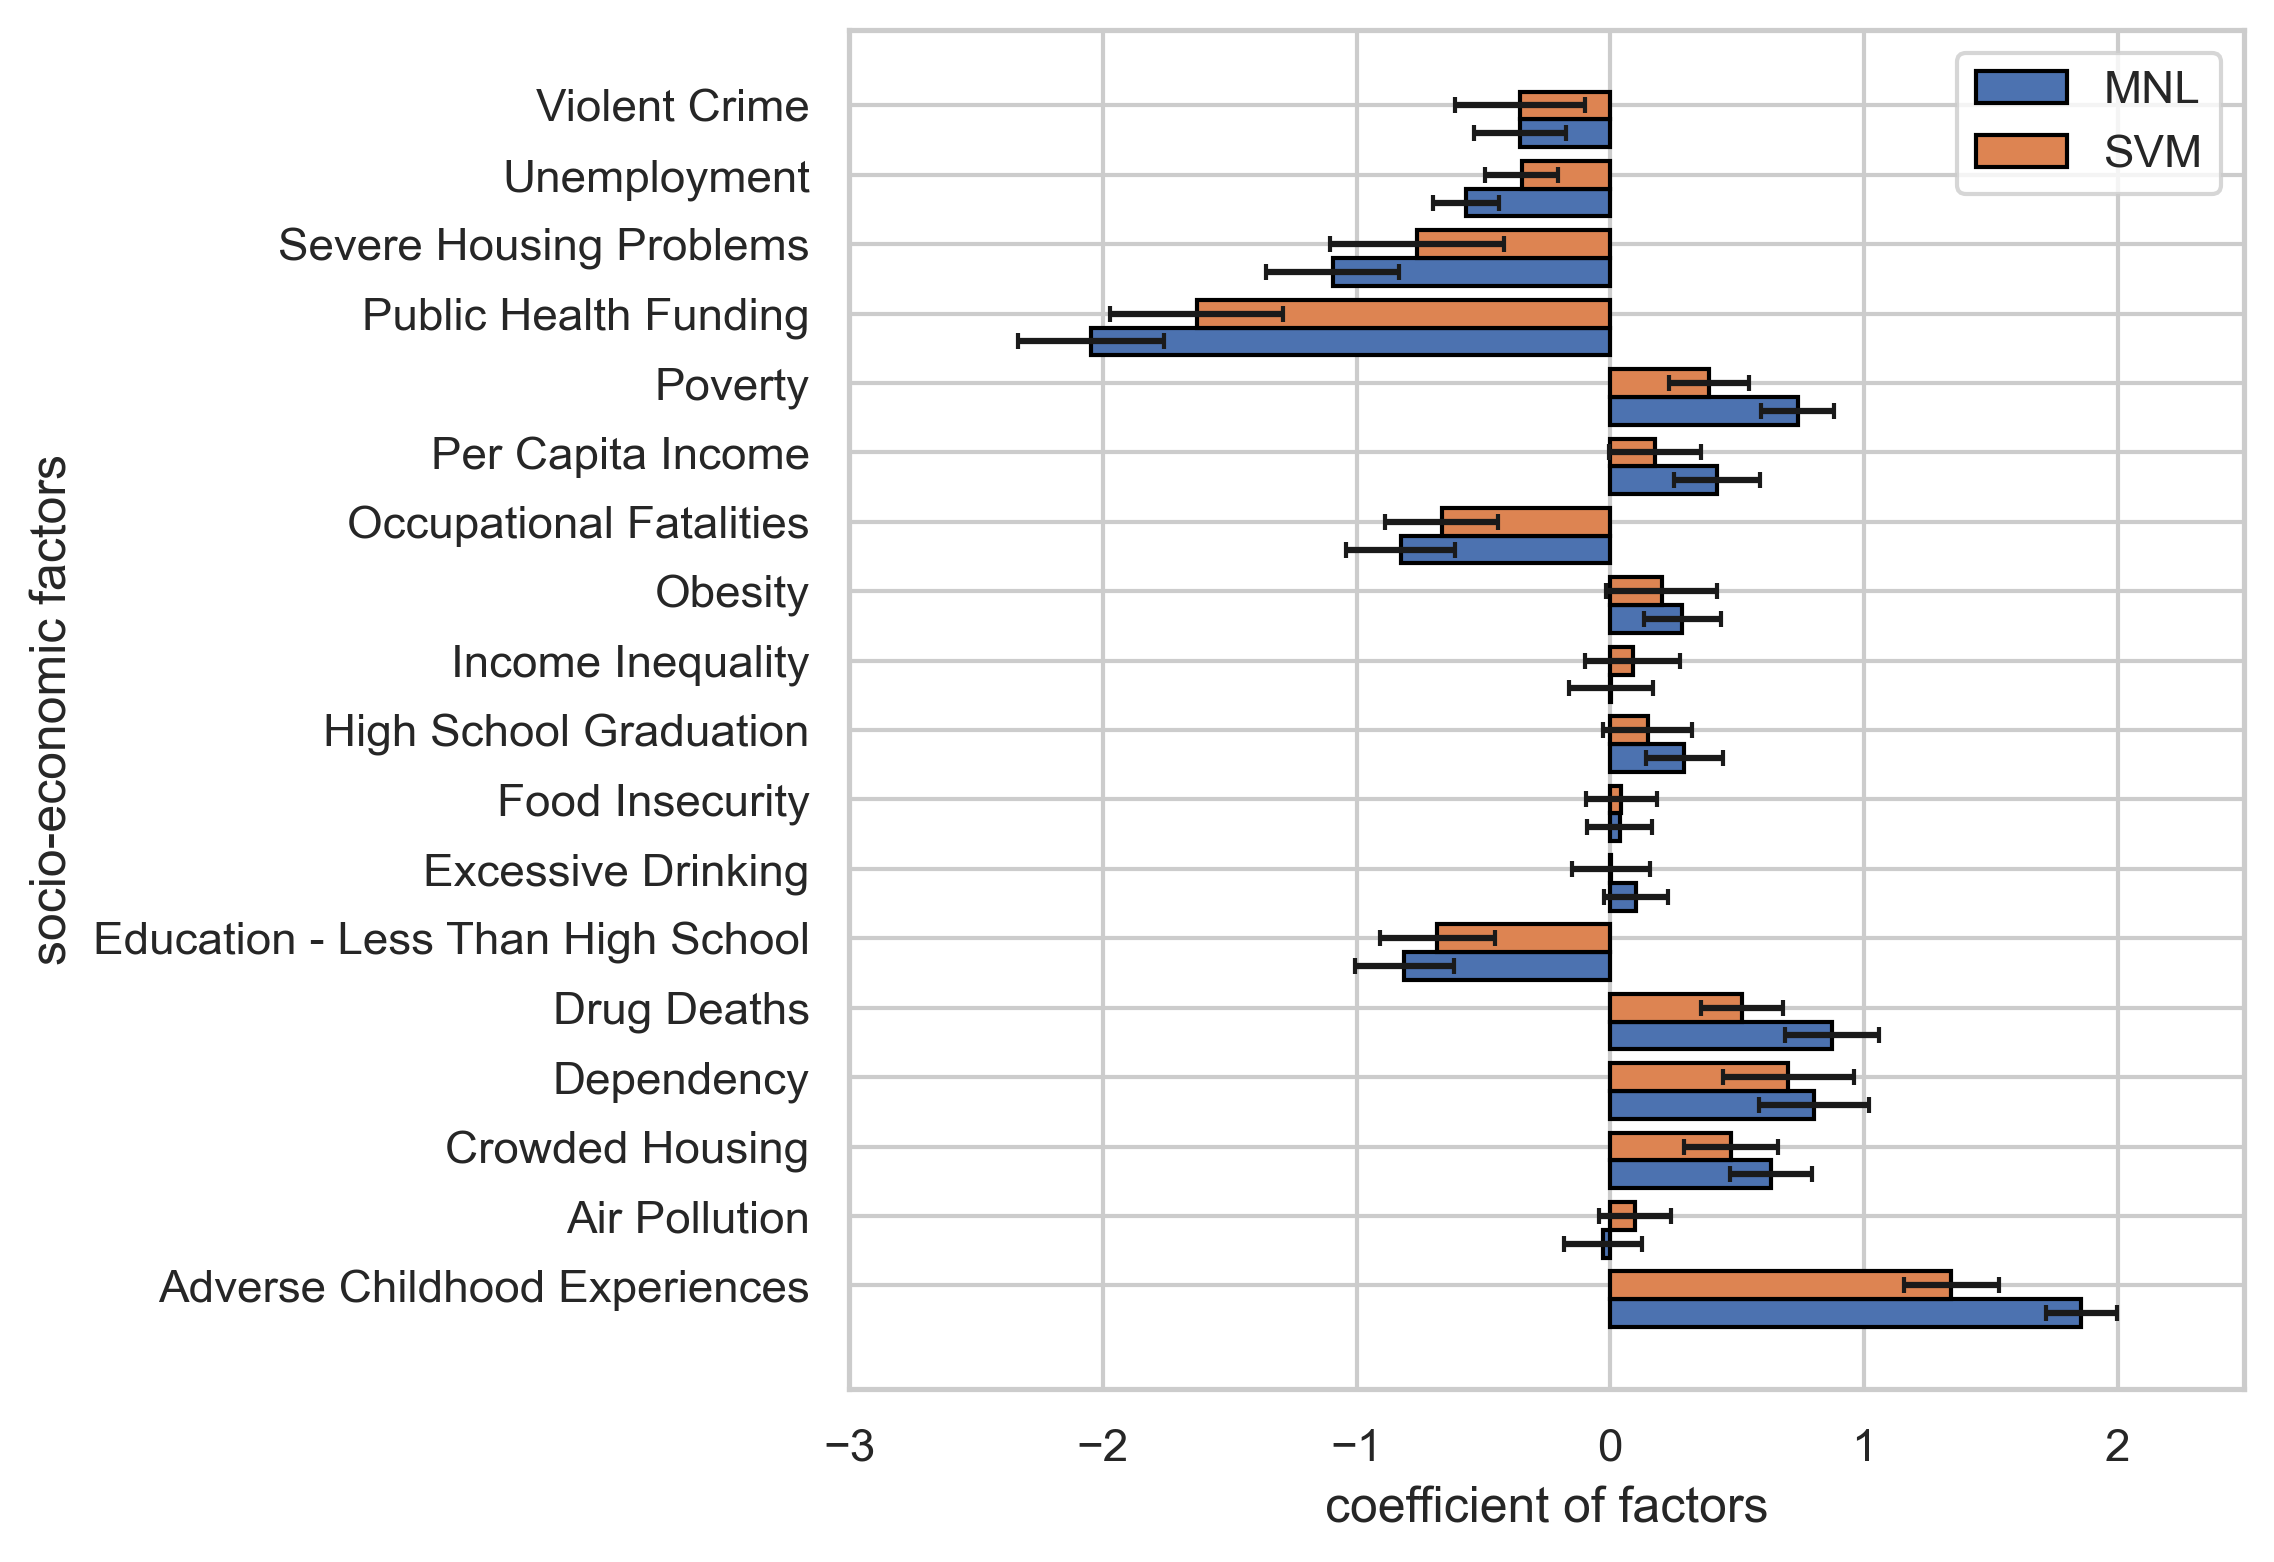

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6),dpi=300)
sns.set(style="whitegrid")
# width of the bars
barHeight = 0.4
 
# Choose the width of the blue bars
bars1 = lr_coef_summary['LR mean']
 
# Choose the width of the cyan bars
bars2 = svm_coef_summary['SVM mean']
 
# Choose the height of the error bars (bars1)
xer1 = lr_coef_summary['LR std']
 
# Choose the height of the error bars (bars2)
xer2 = svm_coef_summary['SVM std']
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barHeight for x in r1]
 
# Create blue bars
plt.barh(r1, bars1, height = barHeight, edgecolor = 'black', xerr=xer1, capsize=2, label='MNL')
 
# Create cyan bars
plt.barh(r2, bars2, height = barHeight, edgecolor = 'black', xerr=xer2, capsize=2, label='SVM')
 
# general layout
plt.yticks([r + barHeight for r in range(len(bars1))], lr_coef_summary.index)
plt.xticks(np.arange(-3,3,1))
plt.xlim(-3,2.5)
plt.ylabel('socio-economic factors')
plt.xlabel('coefficient of factors')
plt.legend()
 
# Show graphic
plt.show()

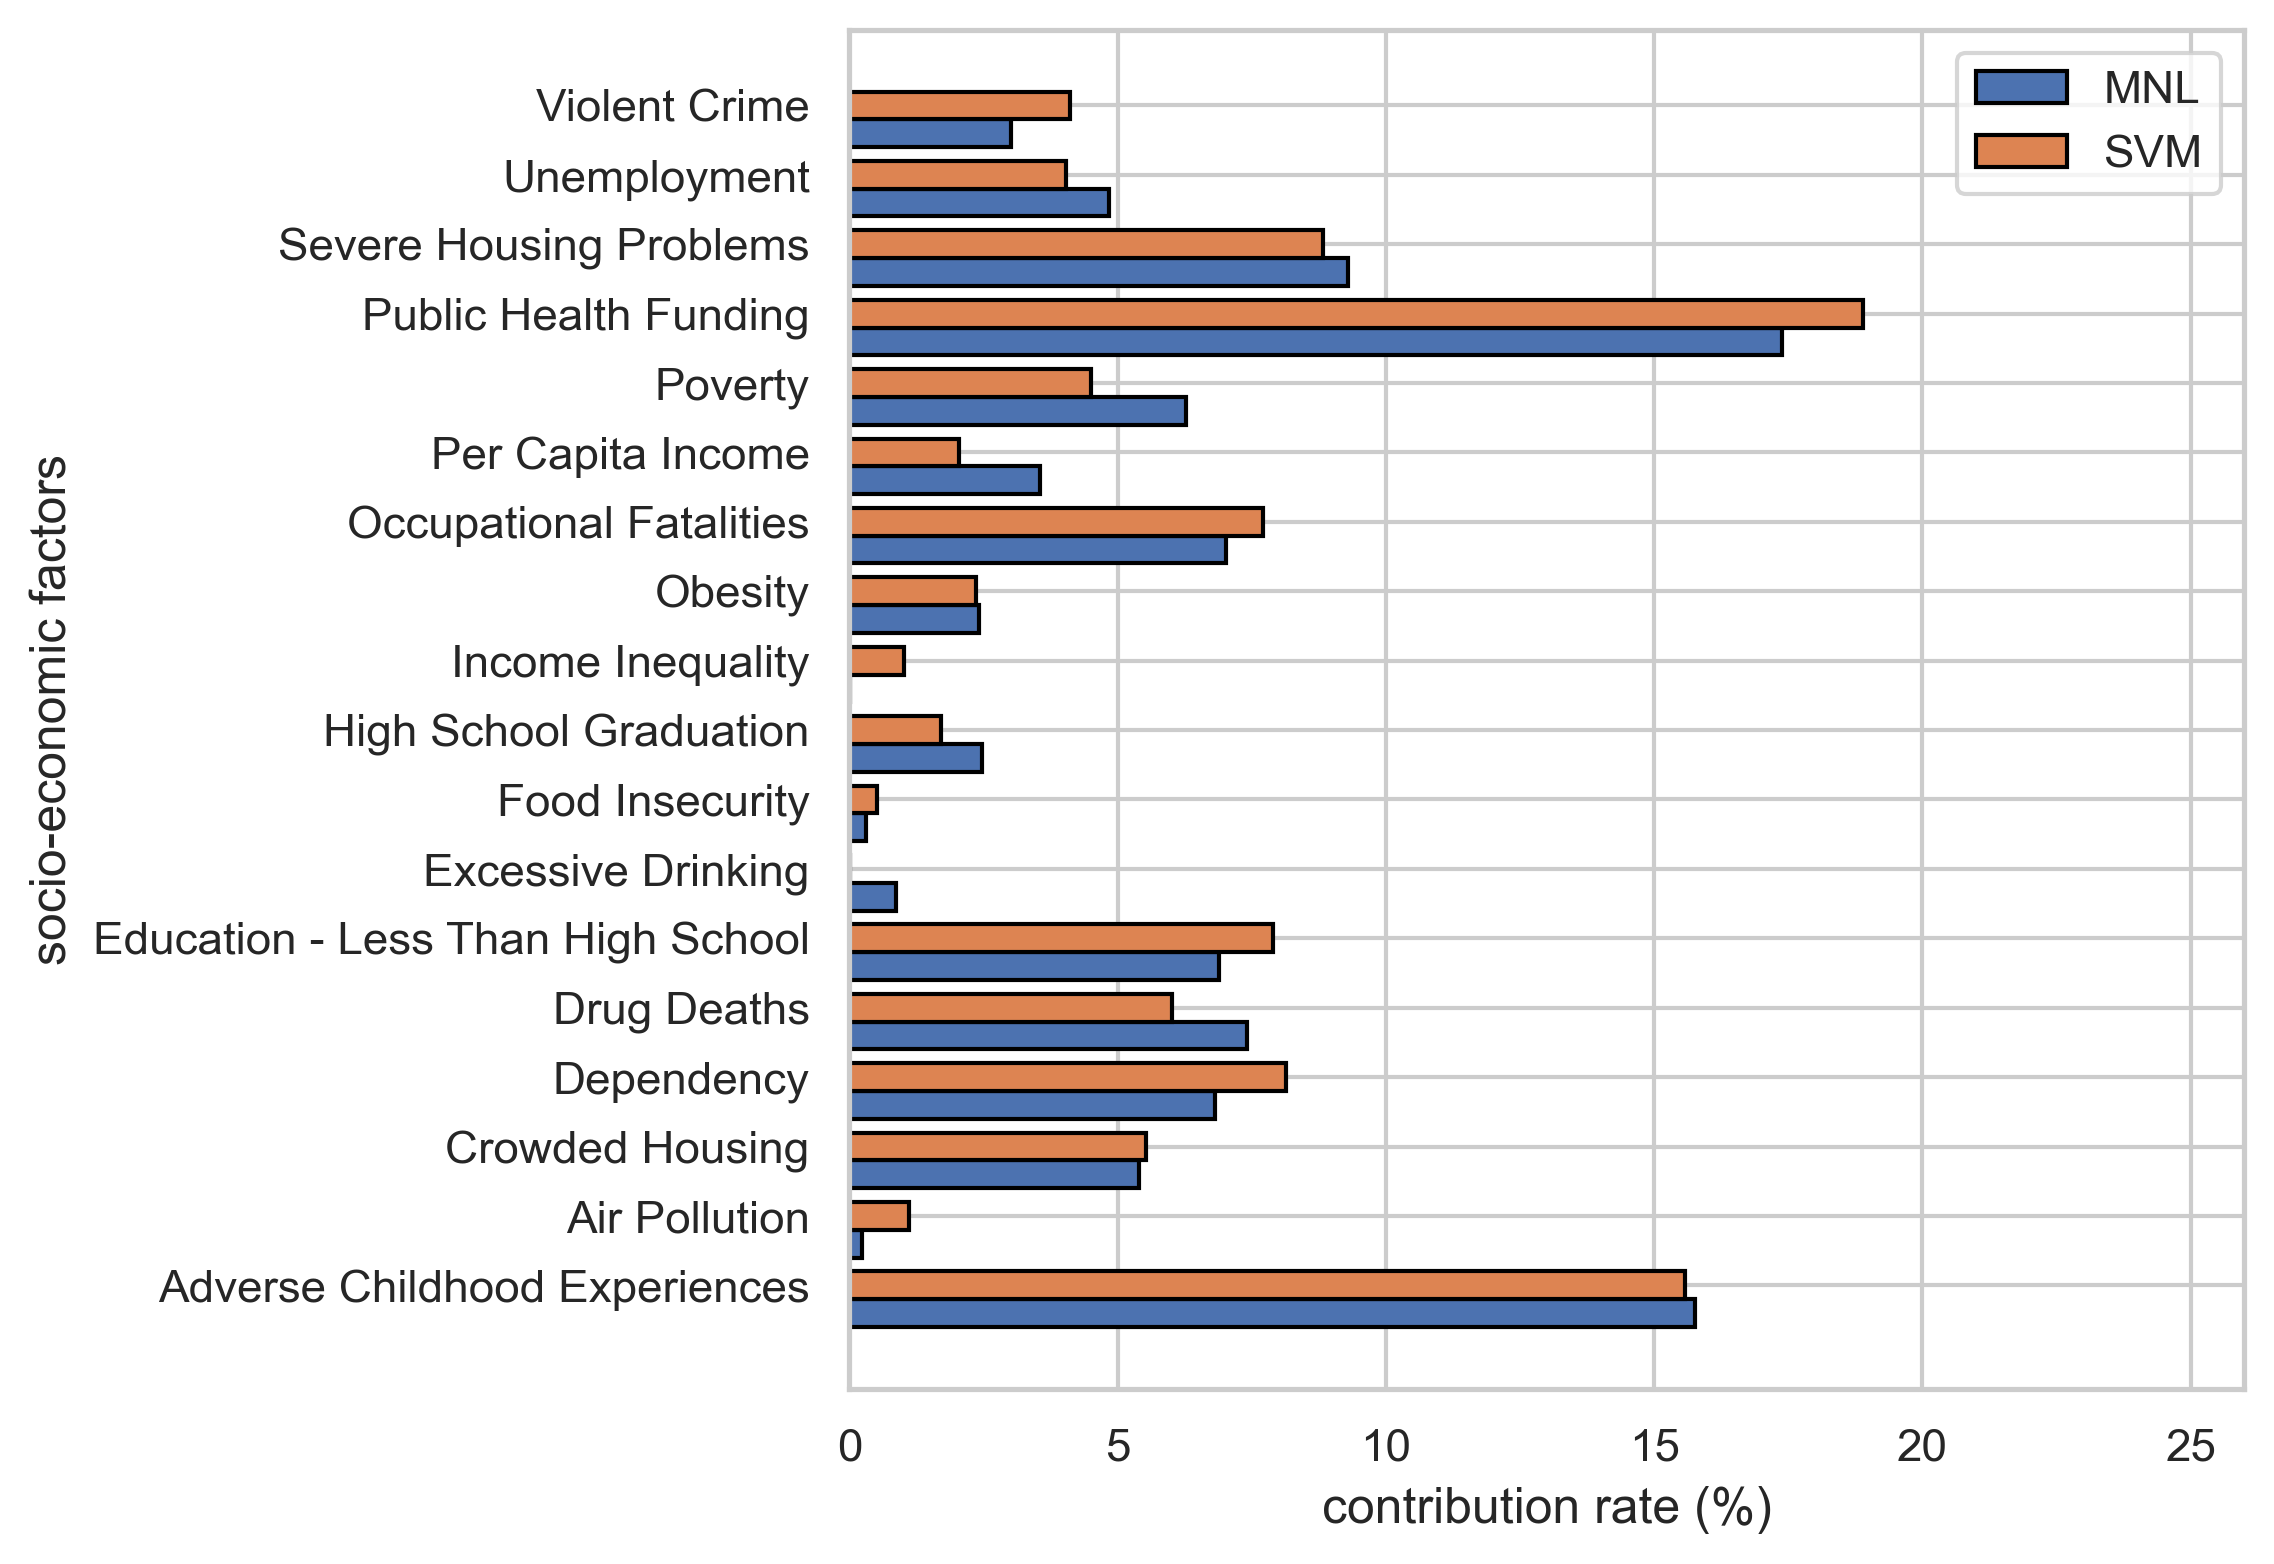

In [107]:
plt.figure(figsize=(6,6),dpi=300)
sns.set(style="whitegrid")
# width of the bars
barHeight = 0.4
 
# Choose the width of the blue bars
bars1 = d_svm['lr_coef_per']
 
# Choose the width of the cyan bars
bars2 = d_svm['svm_coef_per']
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barHeight for x in r1]
 
# Create blue bars
plt.barh(r1, bars1, height = barHeight, edgecolor = 'black', capsize=2, label='MNL')
 
# Create cyan bars
plt.barh(r2, bars2, height = barHeight, edgecolor = 'black', capsize=2, label='SVM')
 
# general layout
plt.yticks([r + barHeight for r in range(len(bars1))], lr_coef_summary.index)
plt.xticks(np.arange(0,26,5))
plt.xlim(0,26)
plt.ylabel('socio-economic factors')
plt.xlabel('contribution rate (%)')
plt.legend()
 
# Show graphic
plt.show()

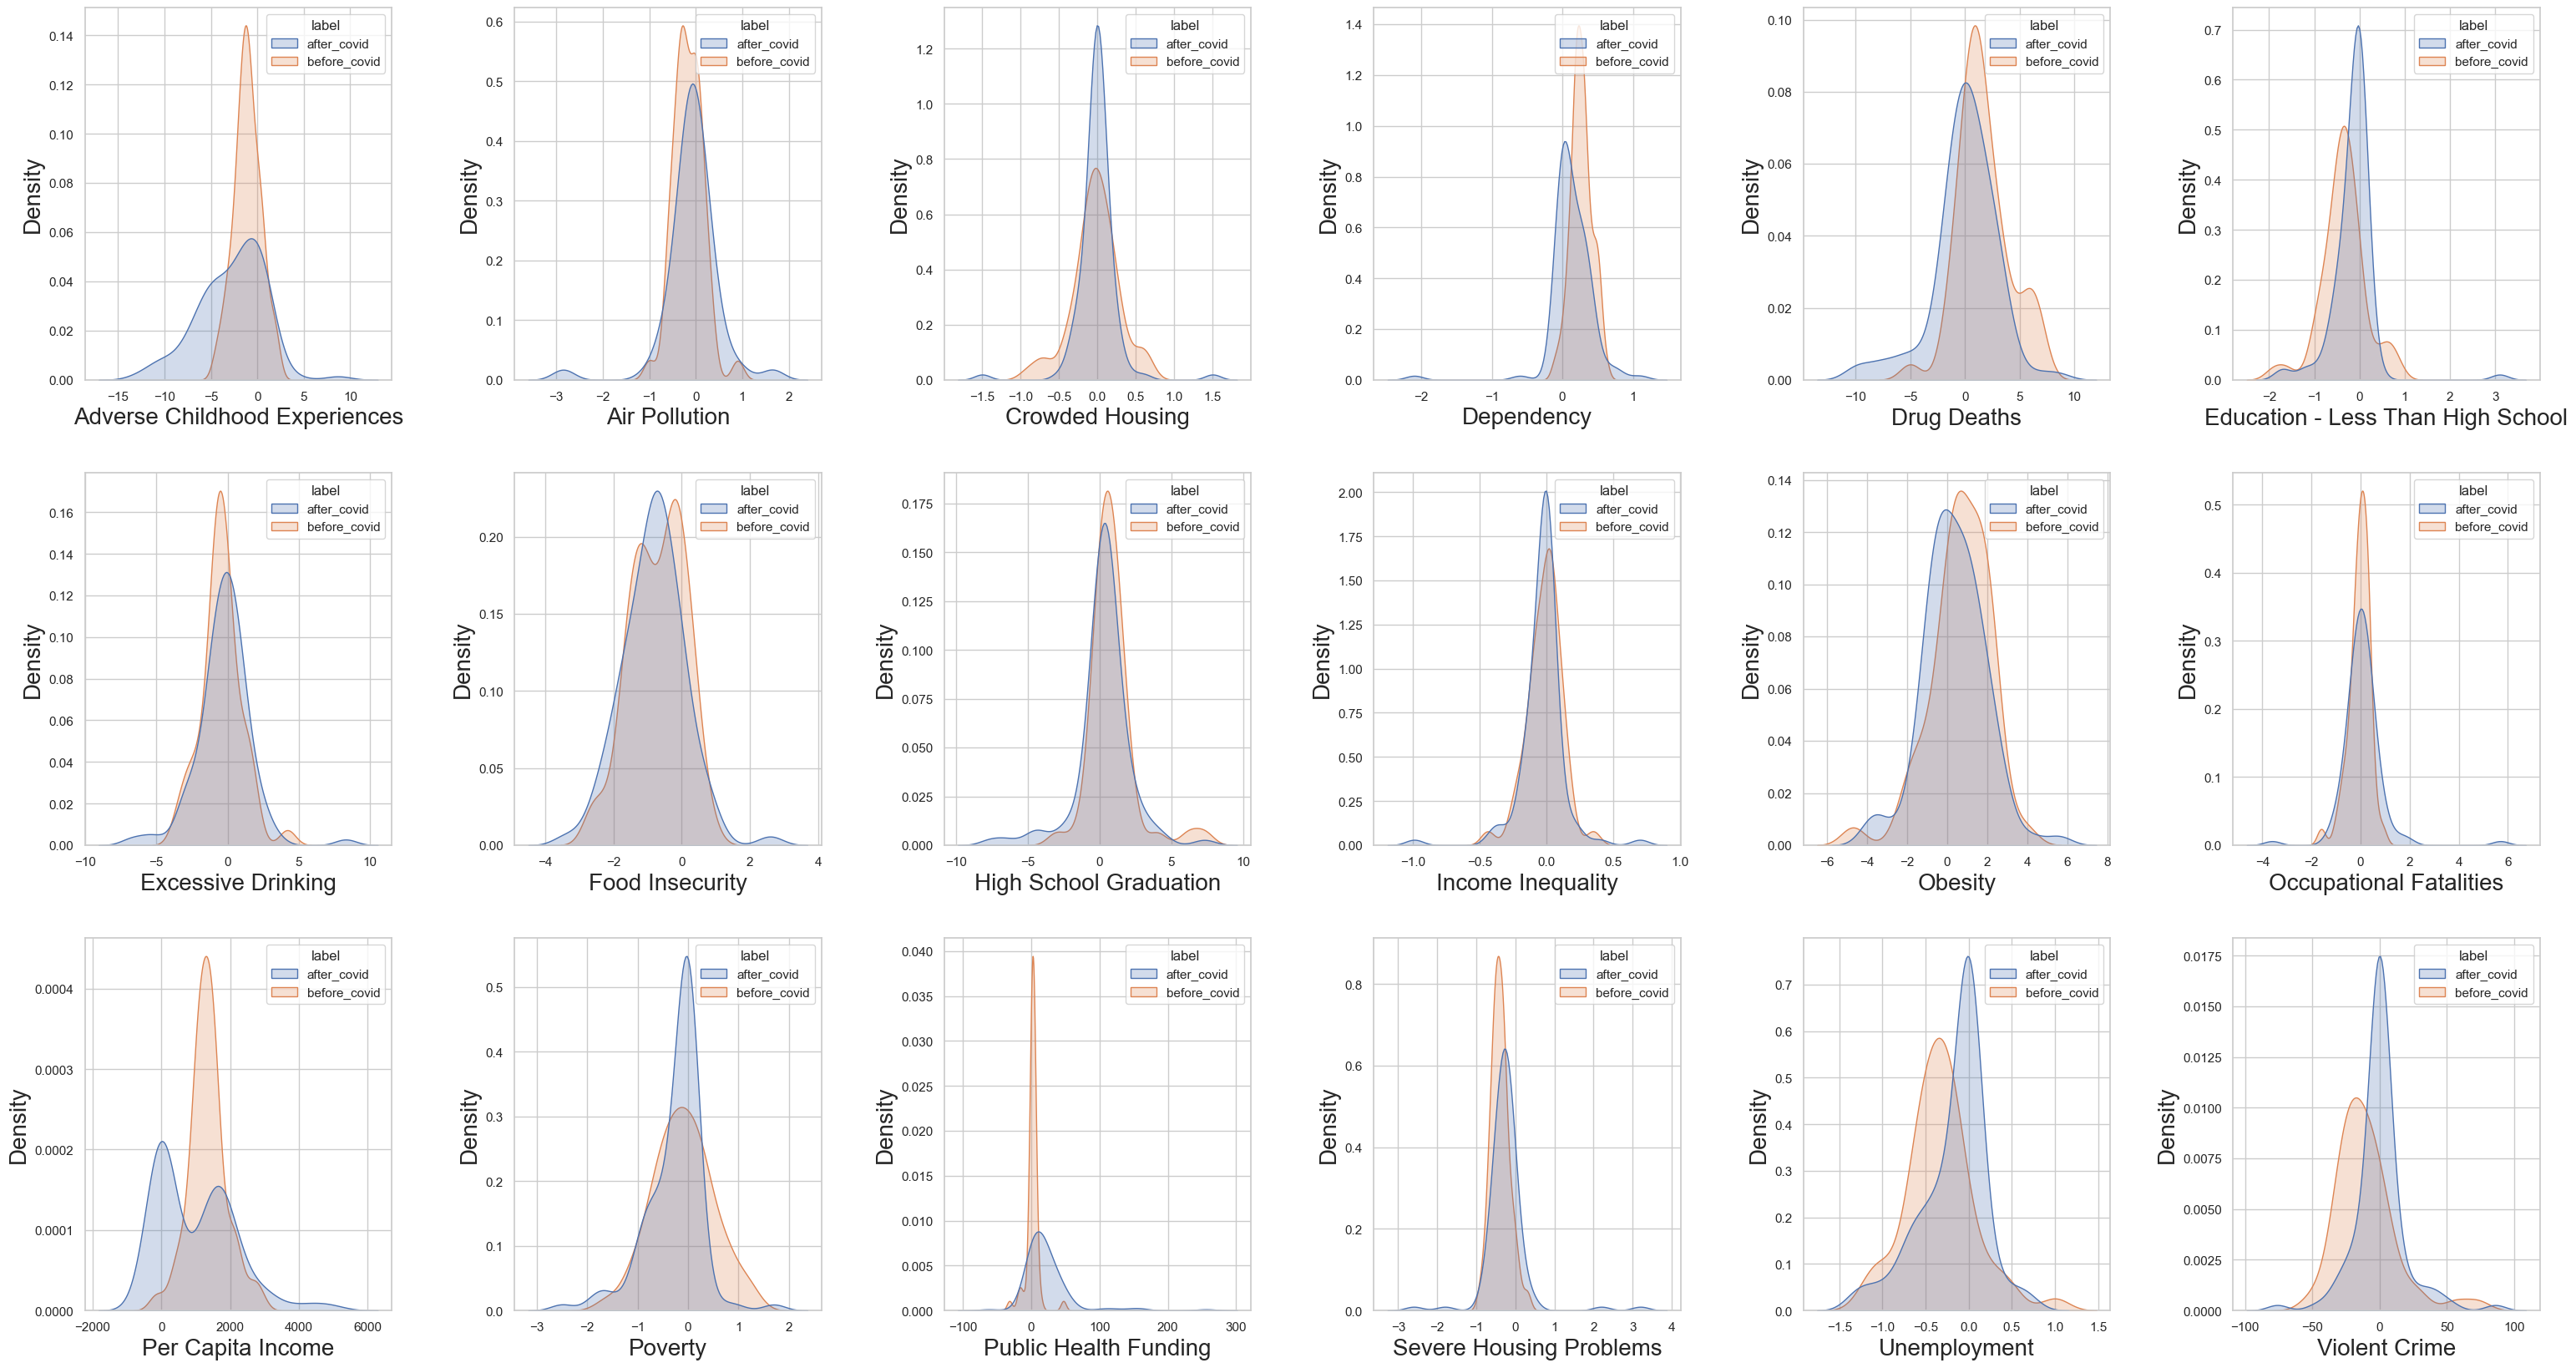

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(6,6),dpi=300)
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="whitegrid")
fig,axes=plt.subplots(3,6,dpi=100)

# plotting both distibutions on the same figure
for i in range(3):
    for j in range(6):
        axes[i,j] = sns.kdeplot(df_concat_shuffle.iloc[:,6*i+j], shade=True,hue=df_concat_shuffle['label'],ax=axes[i,j])
        axes[i,j].set_ylabel('Density',fontdict={'size':20})
        axes[i,j].set_xlabel(df_concat_shuffle.columns[6*i+j],fontdict={'size':20})

        
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=5, 
                    top=4, 
                    wspace=0.4, 
                    hspace=0.25)
plt.show()
# plt.savefig(r'E:\casa\casa0007\final\figure\denplot2.jpg')